-   Assignment requirements:

    -   If you are using Github (recommended), make sure to commit and push your work to GitHub regularly, at least after each exercise. Write short and informative commit messages, and share the link to your assignment with me. If not, you can also send me the **rmd** & **rendered file** via Canvas.

    -   In this assignment, you will not need to code from scratch. Rather, you'll need to fill in code where needed. This assignment has a logisitic regression implementation for a scenario from EDA down to model comparison (and would be useful for whenever you may encounter such a situation in the future).

    -   I want the assignments to begin reflecting a bit more of how you'd be doing things on your own, where you have some prior knowledge and you figure other things out (by referring to documentation, etc.) . In addition to the rmd, I also want you to submit to me **notes** of anything new that you learn while finishing the assignment. And any pain-points, and we'll discuss more.

-   Note:

    -   If you are fitting a model, display the model output in a neatly formatted table. (The `gt` `tidy` and `kable` functions can help!). `Modelsummary` also looks good(https://vincentarelbundock.github.io/modelsummary/articles/modelsummary.html)

    -   Make sure that your plots are clearly labeled – for all axes, titles, etc.\

## Data: General Social Survey

The General Social Survey (GSS) has been used to measure trends in attitudes and behaviors in American society since 1972. In addition to collecting demographic information, the survey includes questions used to gauge attitudes about government spending priorities, confidence in institutions, lifestyle, and many other topics. A full description of the survey may be found here.

The data for this lab are from the 2016 General Social Survey. The original data set contains 2867 observations and 935 variables. We will use and abbreviated data set that includes the following variables:

natmass: Respondent’s answer to the following prompt:

“We are faced with many problems in this country, none of which can be solved easily or inexpensively. I’m going to name some of these problems, and for each one I’d like you to tell me whether you think we’re spending too much money on it, too little money, or about the right amount…are we spending too much, too little, or about the right amount on mass transportation?”

age: Age in years.

sex: Sex recorded as male or female

sei10: Socioeconomic index from 0 to 100

region: Region where interview took place

polviews: Respondent’s answer to the following prompt:

“We hear a lot of talk these days about liberals and conservatives. I’m going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal - point 1 - to extremely conservative - point 7. Where would you place yourself on this scale?”

The data are in gss2016.csv in the data folder.

# EDA

In [35]:
suppressPackageStartupMessages({
    library(dplyr)
    library(ggplot2)
    library(readr)
    library(tidyr)
    library(knitr)
    library(easystats)
    library(broom)
    library(emmeans)
    library(marginaleffects)
    library(performance)
    library(arm)
    library(modelsummary)
})

In [3]:
data <- read.csv("gss2016.csv")
head(data)

,natmass,age,sex,sei10,region,polviews
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,Too little,47,Male,87.9,New england,Moderate
2,Too little,61,Male,38.3,New england,Liberal
3,Too much,43,Female,21.8,New england,Moderate
4,Too little,55,Female,39.7,New england,Slightly liberal
5,About right,53,Female,44.6,New england,Slightly liberal
6,Too little,50,Male,80.7,New england,Slightly liberal


In [4]:
data <- data %>%
  mutate(mass_trans_spend_right = (natmass == "About right"))
head(data)


,natmass,age,sex,sei10,region,polviews,mass_trans_spend_right
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<lgl>
1,Too little,47,Male,87.9,New england,Moderate,FALSE
2,Too little,61,Male,38.3,New england,Liberal,FALSE
3,Too much,43,Female,21.8,New england,Moderate,FALSE
4,Too little,55,Female,39.7,New england,Slightly liberal,FALSE
5,About right,53,Female,44.6,New england,Slightly liberal,TRUE
6,Too little,50,Male,80.7,New england,Slightly liberal,FALSE


In [5]:
#Get proportions
mass_spend_summary <- data %>%
  count(mass_trans_spend_right) %>%
  mutate(proportion = n / sum(n))
mass_spend_summary


mass_trans_spend_right,n,proportion
<lgl>,<int>,<dbl>
FALSE,1218,0.4702703
TRUE,1372,0.5297297


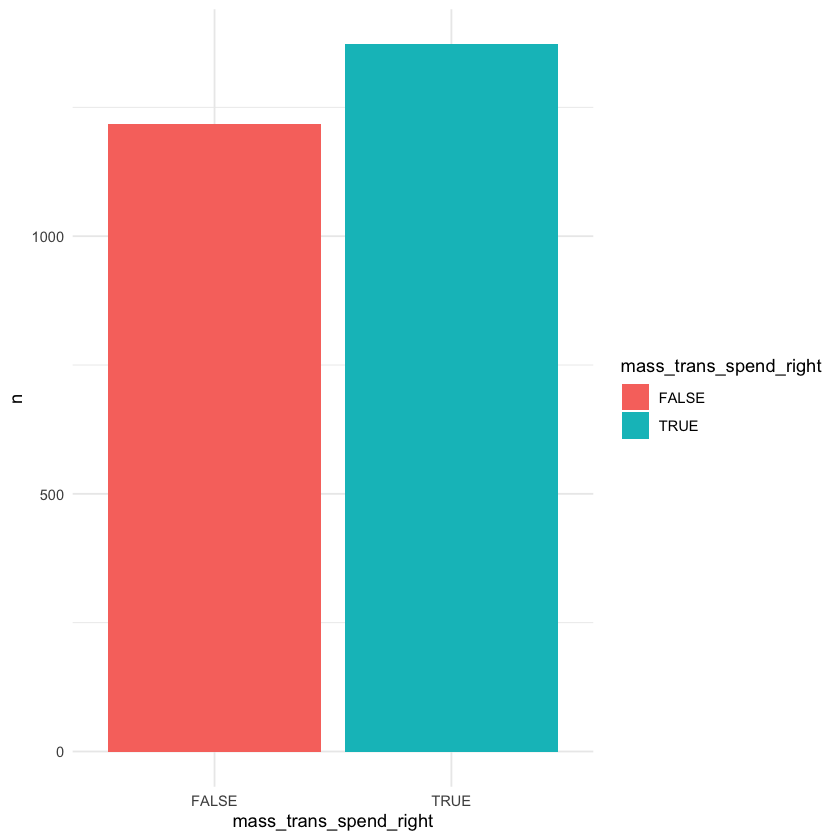

In [6]:
data %>%
  count(mass_trans_spend_right) %>%  # Count occurrences of TRUE/FALSE
  ggplot(aes(x = mass_trans_spend_right, y = n, fill = mass_trans_spend_right)) +
  geom_col() +
  theme_minimal()

In [8]:
data %>%
  count(polviews)

polviews,n
<chr>,<int>
Conservative,395
Extremely liberal,133
Extrmly conservative,104
Liberal,336
Moderate,974
Slghtly conservative,358
Slightly liberal,290


the most freq is 'Moderate'

In [9]:
data <- data %>%
  mutate(polviews = factor(polviews,
                           levels = c("Extremely liberal", "Liberal", "Slightly liberal", "Moderate",
                                      "Slghtly conservative", "Conservative", "Extrmly conservative"),
                           ordered = TRUE))

head(data)

,natmass,age,sex,sei10,region,polviews,mass_trans_spend_right
,<chr>,<chr>,<chr>,<dbl>,<chr>,<ord>,<lgl>
1,Too little,47,Male,87.9,New england,Moderate,FALSE
2,Too little,61,Male,38.3,New england,Liberal,FALSE
3,Too much,43,Female,21.8,New england,Moderate,FALSE
4,Too little,55,Female,39.7,New england,Slightly liberal,FALSE
5,About right,53,Female,44.6,New england,Slightly liberal,TRUE
6,Too little,50,Male,80.7,New england,Slightly liberal,FALSE


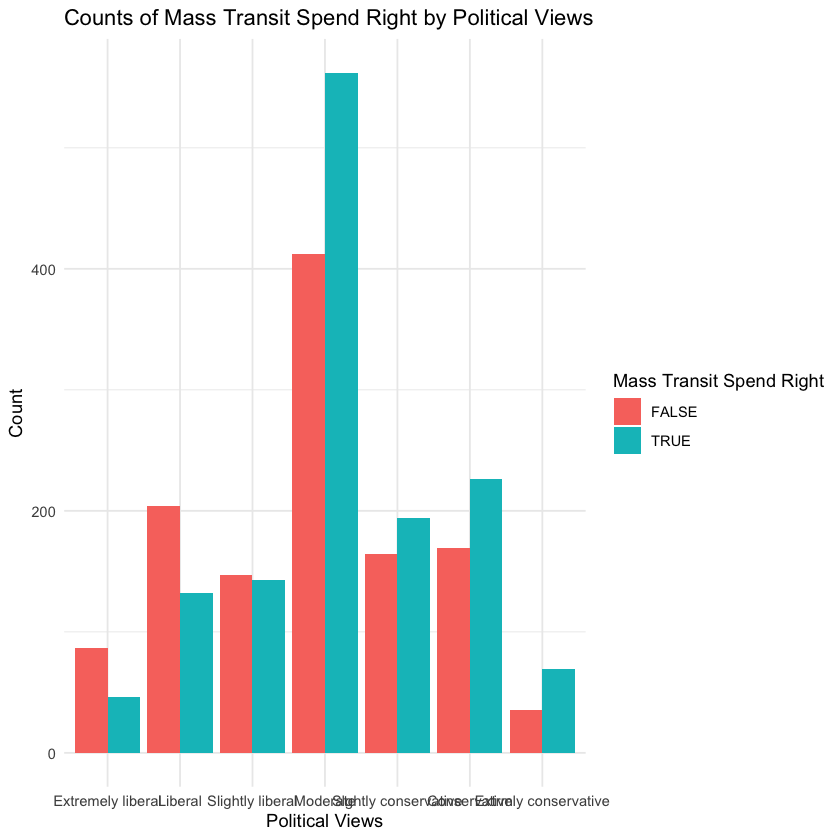

In [10]:
data %>%
  count(polviews, mass_trans_spend_right) %>%  # Count occurrences within polviews
  ggplot(aes(x = polviews, y = n, fill = as.factor(mass_trans_spend_right))) +
  geom_col(position = "dodge") +
  labs(x = "Political Views", y = "Count", fill = "Mass Transit Spend Right",
       title = "Counts of Mass Transit Spend Right by Political Views") +
  theme_minimal()

satisfaction by political views

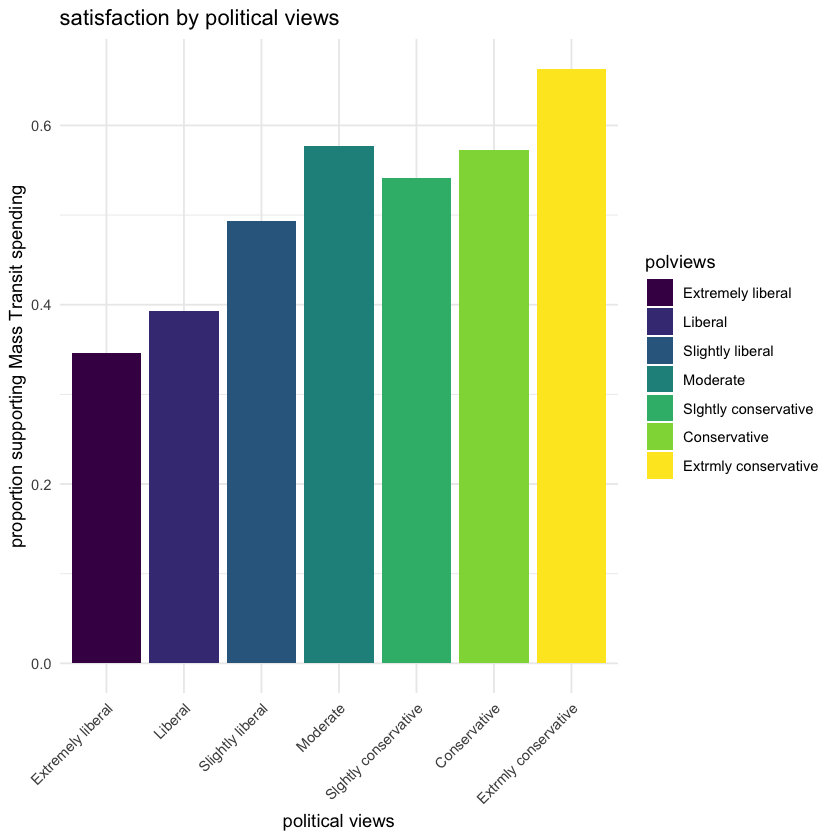

In [11]:
data %>%
  group_by(polviews) %>%
  summarise(prop_true = mean(mass_trans_spend_right)) %>%  # Calculate proportion of TRUE
  ggplot(aes(x = polviews, y = prop_true, fill = polviews)) +
  geom_col() +
  labs(x = "political views", y = "proportion supporting Mass Transit spending",
       title = "satisfaction by political views") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [12]:
data <- data %>%
  mutate(age = ifelse(age == "89 or older", "89", age),
         age = as.numeric(age))


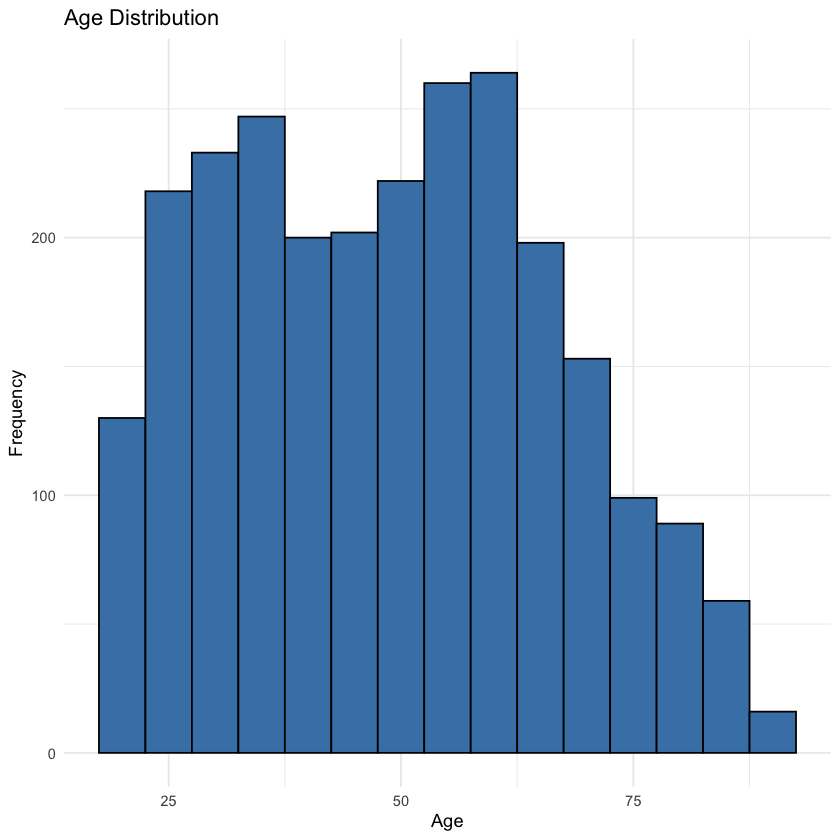

In [13]:
# freq dist of age
ggplot(data, aes(x = age)) +
  geom_histogram(binwidth = 5, fill = "steelblue", color = "black") +  # Adjust binwidth as needed
  labs(title = "Age Distribution", x = "Age", y = "Frequency") +
  theme_minimal()

# Logistic regression

In [14]:
glm_intercept <- glm(mass_trans_spend_right ~ 1, data = data, family = binomial)

summary(glm_intercept)


Call:
glm(formula = mass_trans_spend_right ~ 1, family = binomial, 
    data = data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.11906    0.03937   3.024  0.00249 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3581.3  on 2589  degrees of freedom
Residual deviance: 3581.3  on 2589  degrees of freedom
AIC: 3583.3

Number of Fisher Scoring iterations: 3


In [15]:
b0 = coef(glm_intercept)
b0_transformed <- exp(b0) / (1 + exp(b0)) # logistic transform
ci_lower = b0 - 1.96 * 0.0393685
ci_upper = b0 + 1.96 * 0.0393685

#transforming confidence intervals of coefficients into probabilities
p_lower = exp(ci_lower) / (1 + exp(ci_lower))
p_upper = exp(ci_upper) / (1 + exp(ci_upper))

print(b0_transformed)
print(p_lower)
print(p_upper)

(Intercept) 
  0.5297297 
(Intercept) 
  0.5104727 
(Intercept) 
  0.5488986 


'b0_transformed' shows that the probability of mass_trans_spend_right is TRUE is around 53%, and is significantly different from 50%, suggesting people in general are satisfied with the spending. This is also evident from CIs which do not include 50%.

In [16]:
# ensure sex is categorical
data <- data %>%
  mutate(sex = as.factor(sex))

glm_1 <- glm(mass_trans_spend_right ~ age + sex + sei10,
                 data = data,
                 family = binomial)

glm_1 %>%
  tidy() %>%
  kable()

glm_1 %>%
  tidy(exponentiate = TRUE) %>%
  kable()



|term        |   estimate| std.error| statistic|   p.value|
|:-----------|----------:|---------:|---------:|---------:|
|(Intercept) |  0.8254509| 0.1395587|  5.914722| 0.0000000|
|age         | -0.0061659| 0.0022824| -2.701502| 0.0069027|
|sexMale     | -0.2557439| 0.0798020| -3.204732| 0.0013519|
|sei10       | -0.0062271| 0.0016609| -3.749229| 0.0001774|



|term        |  estimate| std.error| statistic|   p.value|
|:-----------|---------:|---------:|---------:|---------:|
|(Intercept) | 2.2829100| 0.1395587|  5.914722| 0.0000000|
|age         | 0.9938530| 0.0022824| -2.701502| 0.0069027|
|sexMale     | 0.7743403| 0.0798020| -3.204732| 0.0013519|
|sei10       | 0.9937922| 0.0016609| -3.749229| 0.0001774|

# effect of Sex

In [17]:
bsex <- coef(glm_1)["sexMale"]
ci_lower_lo = bsex - 1.96 * 0.0798020
ci_upper_lo = bsex + 1.96 * 0.0798020

ci_lower_or = 1.29 - 1.96 * 0.0798020
ci_upper_or = 1.29 + 1.96 * 0.0798020
emm_sex <- emmeans(glm_1, "sex", type = "response")

print(emm_sex)

 sex     prob     SE  df asymp.LCL asymp.UCL
 Female 0.559 0.0133 Inf     0.533     0.585
 Male   0.495 0.0147 Inf     0.467     0.524

Confidence level used: 0.95 
Intervals are back-transformed from the logit scale 


# effect of age

In [18]:
bage <- coef(glm_1)["age"]

ci_lower_lo_age = bage - 1.96 * 0.0022824
ci_upper_lo_age = bage + 1.96 * 0.0022824

c(LO = bage, CI_Lower = ci_lower_lo_age, CI_Upper = ci_upper_lo_age)

or_age <- exp(bage)
ci_lower_or_age = exp(ci_lower_lo_age)
ci_upper_or_age = exp(ci_upper_lo_age)

c(OR = or_age, CI_Lower = ci_lower_or_age, CI_Upper = ci_upper_or_age)

emm_age <- emmeans(glm_1, "age", at = list(age = seq(min(data$age), max(data$age), by = 10)), type = "response")
print(emm_age)

LO.age CI_Lower.age CI_Upper.age 
-0.006165940 -0.010639444 -0.001692436

OR.age CI_Lower.age CI_Upper.age 
    0.993853     0.989417     0.998309

 age  prob      SE  df asymp.LCL asymp.UCL
  18 0.574 0.01980 Inf     0.535     0.613
  28 0.559 0.01530 Inf     0.529     0.589
  38 0.544 0.01160 Inf     0.521     0.567
  48 0.529 0.00993 Inf     0.509     0.548
  58 0.513 0.01120 Inf     0.491     0.535
  68 0.498 0.01470 Inf     0.469     0.527
  78 0.482 0.01930 Inf     0.445     0.520
  88 0.467 0.02430 Inf     0.420     0.515

Results are averaged over the levels of: sex 
Confidence level used: 0.95 
Intervals are back-transformed from the logit scale 


A one unit increase in age is associated with a decrease in the log-odds of being satisfied with spending on mass transportation by -0.0061659 units (95% CI [-0.010, -0.002]), holding all other variables constant. The odds ratio is 0.9938530 (95% CI [0.989, 0.998]) which confirms the negative relationship implied by the log-odds coefficient.

Specifically, for each additional unit of age, the odds of being satisfied with mass transportation spending decrease by a factor of about 0.9938, or approximately 0.62% per unit increase in age, holding other factors constant.

# effect of SES index

In [19]:
bses <- coef(glm_1)["sei10"]
ci_lower_lo_ses = bses - 1.96 * 0.0001774
ci_upper_lo_ses = bses + 1.96 * 0.0001774

c(LO = bses, CI_Lower = ci_lower_lo_ses, CI_Upper = ci_upper_lo_ses)

or_ses <- exp(bses)
ci_lower_or_ses = exp(ci_lower_lo_ses)
ci_upper_or_ses = exp(ci_upper_lo_ses)

c(OR = or_ses, CI_Lower = ci_lower_or_ses, CI_Upper = ci_upper_or_ses)

emm_ses <- emmeans(glm_1, "sei10", type = "response")
print(emm_ses)

LO.sei10 CI_Lower.sei10 CI_Upper.sei10 
  -0.006227141   -0.006574845   -0.005879437

OR.sei10 CI_Lower.sei10 CI_Upper.sei10 
     0.9937922      0.9934467      0.9941378

 sei10  prob      SE  df asymp.LCL asymp.UCL
  46.1 0.527 0.00992 Inf     0.508     0.547

Results are averaged over the levels of: sex 
Confidence level used: 0.95 
Intervals are back-transformed from the logit scale 


A one unit increase in ses is associated with a decrease in the log-odds of being satisfied with spending on mass transportation by -0.006227 units (95% CI [-0.00657, -0.005879]), holding all other variables constant. The odds ratio is 0.99379 (95% CI [0.993, 0.994]) which confirms the negative relationship implied by the log-odds coefficient.

Specifically, for each additional unit of ses, the odds of being satisfied with mass transportation spending decrease by a factor of about 0.99379, or approximately 0.63% per unit increase in ses, holding other factors constant.

# marginal effects
Let's examine the results on the probability scale.

In [20]:
avg_comparisons(glm_1, comparison = "difference") %>%
  kable()



|term  |contrast      |   estimate| std.error| statistic|   p.value|   s.value|   conf.low|  conf.high|
|:-----|:-------------|----------:|---------:|---------:|---------:|---------:|----------:|----------:|
|age   |+1            | -0.0015153| 0.0005579| -2.716128| 0.0066050|  7.242217| -0.0026088| -0.0004219|
|sei10 |+1            | -0.0015304| 0.0004039| -3.789362| 0.0001510| 12.692830| -0.0023219| -0.0007388|
|sex   |Male - Female | -0.0630688| 0.0196461| -3.210251| 0.0013262|  9.558494| -0.1015743| -0.0245632|

The marginal effect of age is -0.0015153 (95% CI [-0.0026088, -0.0004219]). So, for each additional unit increase of age, the probability of being satisfied with mass transportation spending decreases by approximately 0.1515 percentage points, holding other factors constant (p = 0.0066050).

The marginal effect of SES is -0.0015304 (95% CI [-0.0023219, -0.0007388]). For each one-unit increase in the socioeconomic index, the probability of being satisfied with mass transportation spending decreases by approximately 0.15304 percentage points, holding other variables constant (p = 0.0001510).

The marginal effect for being male compared to female is -0.0630688 (95% CI [-0.1015743, -0.0245632]). This indicates that males are, on average, about 6.3% percentage points less likely than females to be satisfied with mass transportation spending, holding other factors constant (p = 0.0013262).

# model comparison

In [21]:
fit_2 = glm(mass_trans_spend_right ~ age + sex + sei10,
                 data = data,
                 family = binomial)
fit_3 = glm(mass_trans_spend_right ~ age + sex + sei10 + polviews,
                 data = data,
                 family = binomial)

test_likelihoodratio(fit_2, fit_3) %>% kable()

# equivalently
anova(fit_2, fit_3, test = "Chisq")



|      |Name  |Model | df| df_diff|     Chi2|  p|
|:-----|:-----|:-----|--:|-------:|--------:|--:|
|fit_2 |fit_2 |glm   |  4|      NA|       NA| NA|
|fit_3 |fit_3 |glm   | 10|       6| 63.02844|  0|

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2586,3545.796,NA,NA,NA
2,2580,3482.768,6,63.02844,1.089119e-11


the model with 'polviews' is significantly better

# visualization

In [22]:
library(ggeffects)

str(data)

data <- data %>%
  mutate(polviews = as.factor(polviews))

data <- data %>%
  mutate(mass_trans_spend_right = as.numeric(mass_trans_spend_right))

fit_3 <- glm(mass_trans_spend_right ~ age + sex + sei10 + polviews,
             data = data,
             family = binomial)



Attaching package: ‘ggeffects’


The following object is masked from ‘package:easystats’:

    install_latest




'data.frame':	2590 obs. of  7 variables:
 $ natmass               : chr  "Too little" "Too little" "Too much" "Too little" ...
 $ age                   : num  47 61 43 55 53 50 23 71 86 32 ...
 $ sex                   : Factor w/ 2 levels "Female","Male": 2 2 1 1 1 2 1 2 1 2 ...
 $ sei10                 : num  87.9 38.3 21.8 39.7 44.6 80.7 20.1 32 13.2 20.8 ...
 $ region                : chr  "New england" "New england" "New england" "New england" ...
 $ polviews              : Ord.factor w/ 7 levels "Extremely liberal"<..: 4 2 4 3 3 3 5 6 5 3 ...
 $ mass_trans_spend_right: logi  FALSE FALSE FALSE FALSE TRUE FALSE ...


In [23]:
colors <- c("Extremely liberal" = "black",
            "Liberal" = "#0e2f44",  # Dark blue
            "Slightly liberal" = "#1d5a6c",  # Less dark blue
            "Moderate" = "#358ca3",  # Medium blue
            "Slghtly conservative" = "#71b9d1",  # Light blue
            "Conservative" = "#a6dcef",  # Lighter blue
            "Extrmly conservative" = "#d0f0fd")  # Very light blue


pp_pol <- ggemmeans(fit_3, terms = "polviews")
print(pp_pol)

# Predicted probabilities of mass_trans_spend_right

polviews             | Predicted |     95% CI
---------------------------------------------
Extremely liberal    |      0.34 | 0.27, 0.43
Liberal              |      0.39 | 0.34, 0.45
Slightly liberal     |      0.49 | 0.43, 0.54
Moderate             |      0.57 | 0.53, 0.60
Slghtly conservative |      0.55 | 0.50, 0.60
Conservative         |      0.58 | 0.53, 0.63
Extrmly conservative |      0.66 | 0.57, 0.75

Adjusted for:
*   age = 48.90
* sei10 = 46.07


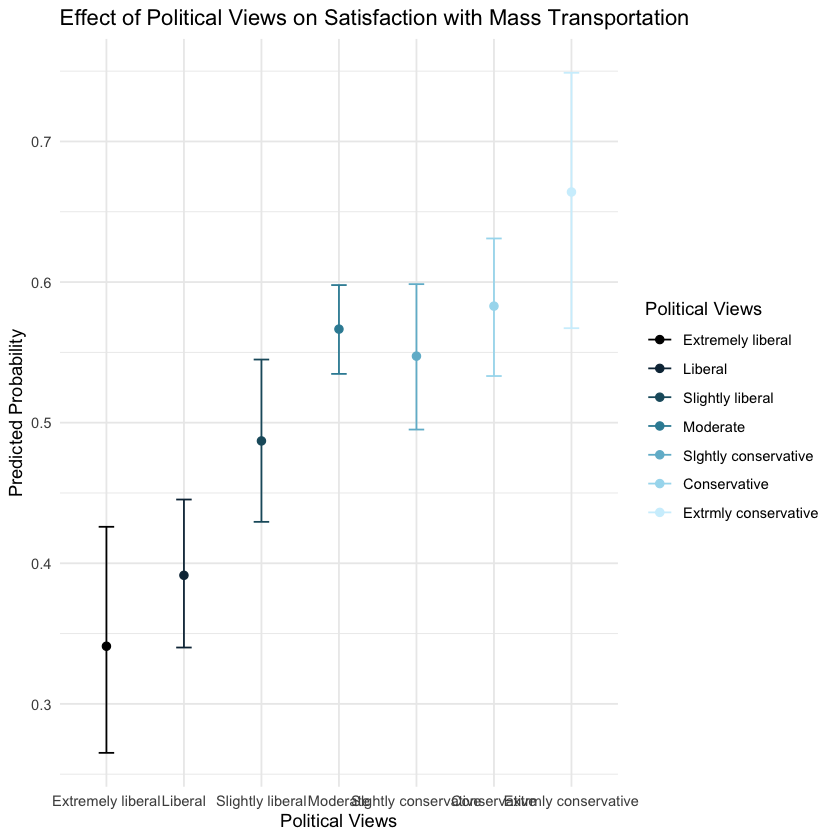

In [24]:

# Adjusted plot with gradient colors
pol_plot <- ggplot(pp_pol, aes(x = x, y = predicted, color = x)) +
  geom_point(size = 2) +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0.2) +
  scale_color_manual(values = colors) +
  labs(title = "Effect of Political Views on Satisfaction with Mass Transportation",
       x = "Political Views", y = "Predicted Probability",
       color = "Political Views") +
  theme_minimal()

pol_plot

The above plot shows the probability of being satisfied with Mass transportation increases when political views become more conservative, when controlling for age and SES.

# Predicted probabilities of mass_trans_spend_right

sex    | Predicted |     95% CI
-------------------------------
Female |      0.55 | 0.51, 0.58
Male   |      0.48 | 0.44, 0.51

Adjusted for:
*   age = 48.90
* sei10 = 46.07


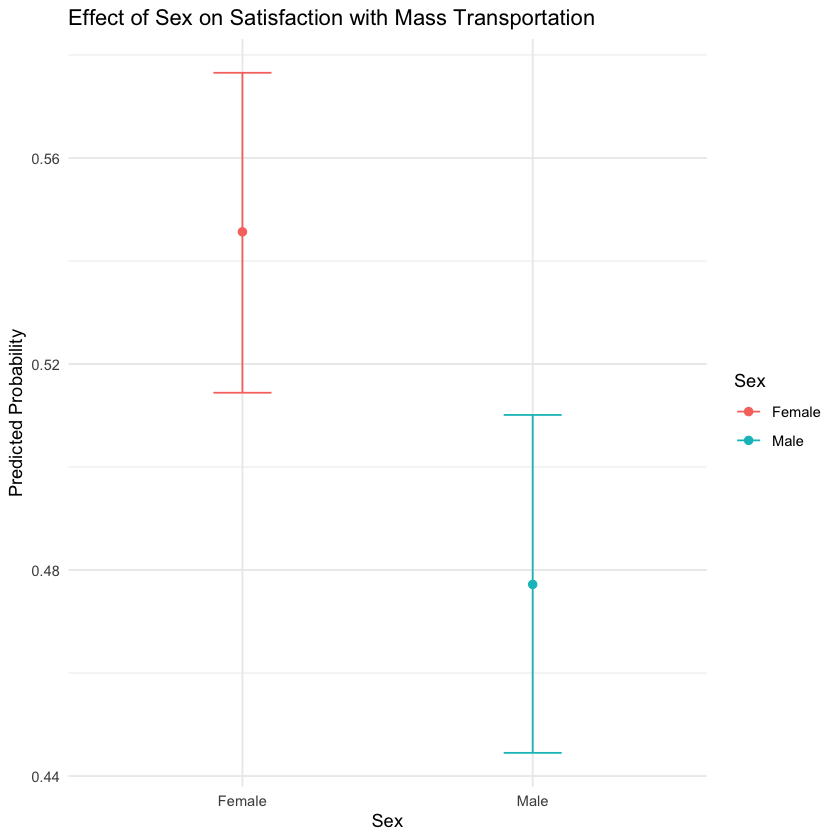

In [25]:

pp_sex <- ggemmeans(fit_3, terms = c("sex"))

sex_plot <- ggplot(pp_sex, aes(x = x, y = predicted, color = x)) +
  geom_point(size = 2) +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0.2) +
  labs(title = "Effect of Sex on Satisfaction with Mass Transportation",
       x = "Sex", y = "Predicted Probability",
       color = "Sex") +
  theme_minimal()

print(pp_sex)
sex_plot

The above plot shows that women are in general more satisfied with Mass transportation than man, when controlling for age and SES.

# Predicted probabilities of mass_trans_spend_right

sei10 | Predicted |     95% CI
------------------------------
 0.00 |      0.57 | 0.52, 0.61
24.10 |      0.54 | 0.51, 0.57
31.60 |      0.53 | 0.50, 0.56
39.50 |      0.52 | 0.49, 0.55
50.40 |      0.51 | 0.48, 0.53
59.40 |      0.50 | 0.47, 0.52
70.30 |      0.48 | 0.45, 0.51
99.90 |      0.45 | 0.40, 0.50

Adjusted for:
* age = 48.90



Not all rows are shown in the output. Use `print(..., n = Inf)` to show
  all rows.



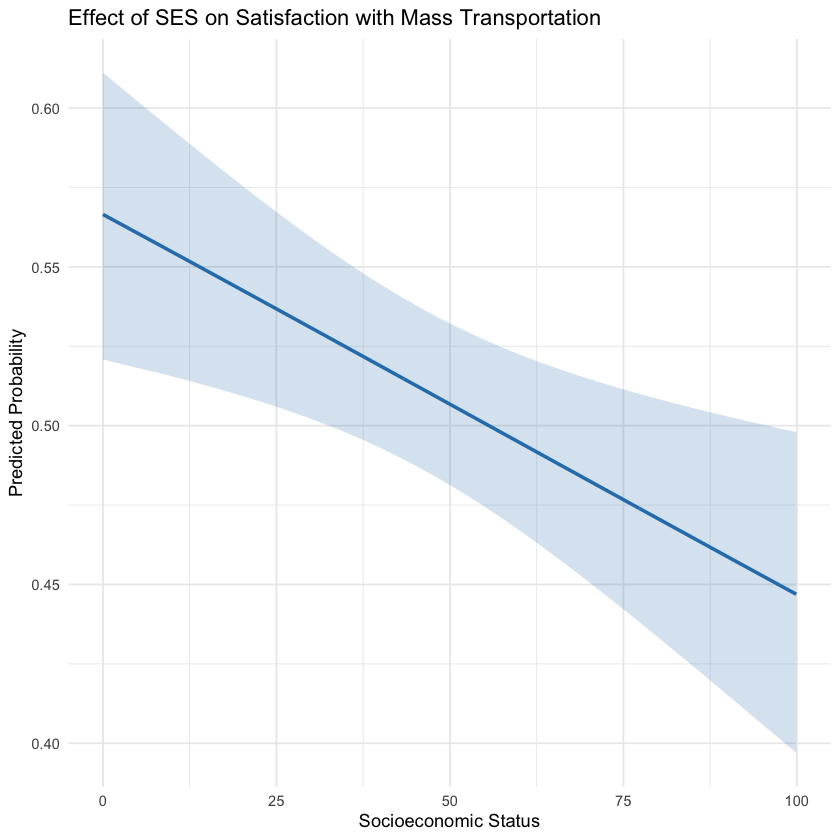

In [27]:
pp_ses <- ggemmeans(fit_3, terms = "sei10 [all]")

ses_plot <-  ggplot(pp_ses, aes(x = x, y = predicted)) +
  geom_line(color = "#2c7fb8", size = 1) +
  geom_ribbon(aes(ymin = conf.low, ymax = conf.high), fill = "#2c7fb8", alpha = 0.2) +  # Add a confidence interval band
  labs(title = "Effect of SES on Satisfaction with Mass Transportation",
       x = "Socioeconomic Status", y = "Predicted Probability") +
  theme_minimal() +
  theme(legend.position = "none")

print(pp_ses)
ses_plot

The above plot shows that the satisfaction for Mass transportation decreases with increase in SES, while controlling for age.

# model assumptions

Is the logistic model a good choice for this data?

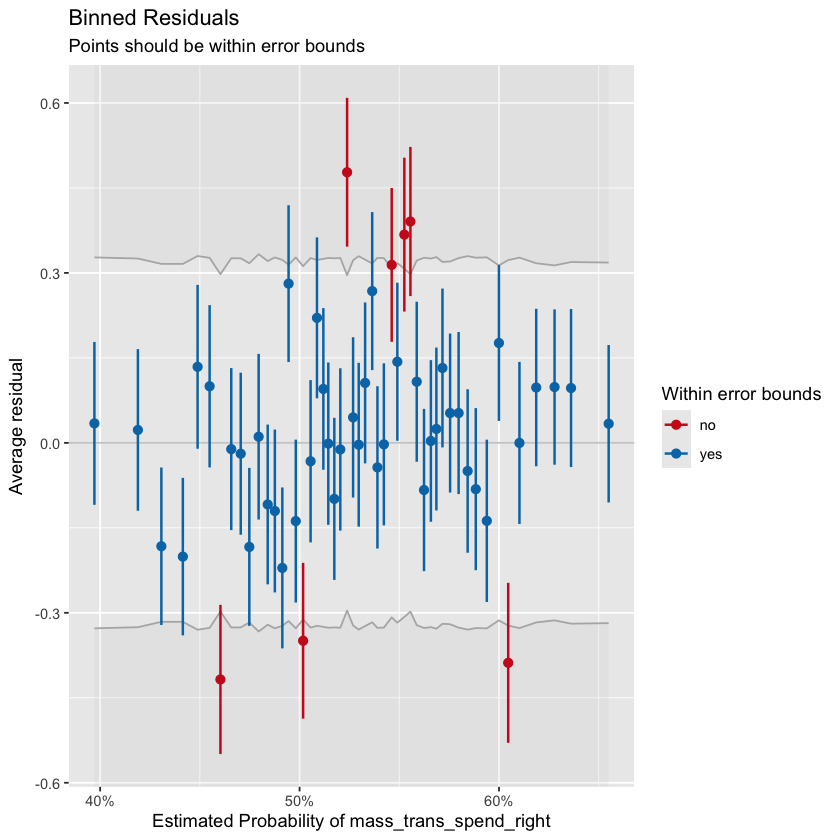

In [34]:
bin_res = binned_residuals(fit_2)
print(bin_res)
plot(bin_res)

The model does not seem to fit the data well, because of low proportion of data (86% as opposed to the ideal >95%) within the error bound.

In [29]:
r2_mcfadden(fit_2)

# R2 for Generalized Linear Regression
       R2: 0.010
  adj. R2: 0.009

The model explains 1% of variance, suggesting a poor fit.

,xbar,ybar,n,x.lo,x.hi,se,CI_low,CI_high,group
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
conf_int,0.00000,-0.011793983,80,0.0,0.0,0.2550301,-0.124107516,0.10051955,yes
conf_int1,12.20541,-0.269309119,37,9.0,12.6,0.3845044,-0.437262770,-0.10135547,yes
conf_int2,13.54259,-0.107946954,54,13.2,13.6,0.3174032,-0.247049617,0.03115571,yes
conf_int3,14.18235,-0.088890080,34,14.0,14.8,0.4006327,-0.264350329,0.08657017,yes
conf_int4,18.75600,-0.222304869,75,15.8,19.6,0.2713304,-0.339827533,-0.10478221,yes
conf_int5,20.03182,0.218663094,44,19.7,20.1,0.3347770,0.071524273,0.36580192,yes
conf_int6,20.67333,-0.277131083,45,20.5,20.7,0.3409253,-0.428095927,-0.12616624,yes
conf_int7,21.39322,0.034109141,59,20.8,21.6,0.3007066,-0.097529681,0.16574796,yes
conf_int8,21.83103,0.526726461,29,21.8,22.4,0.3579303,0.368073911,0.68537901,no


,xbar,ybar,n,x.lo,x.hi,se,CI_low,CI_high,group
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
conf_int,19.29508,0.252699356,61,18,20,0.2796780,0.130747839,0.374650874,yes
conf_int1,21.57971,-0.082685721,69,21,22,0.2806257,-0.205265793,0.039894350,yes
conf_int2,23.00000,0.134071722,47,23,23,0.3249980,-0.011494502,0.279637946,yes
conf_int3,24.00000,-0.077045204,32,24,24,0.4203514,-0.257856888,0.103766480,yes
conf_int4,25.00000,-0.050310988,49,25,25,0.3286766,-0.196276258,0.095654282,yes
conf_int5,26.57778,0.080751232,90,26,27,0.2402476,-0.025327864,0.186830328,yes
conf_int6,28.00000,0.236950312,40,28,28,0.3484210,0.081669331,0.392231293,yes
conf_int7,29.00000,0.263383294,53,29,29,0.3013667,0.129648460,0.397118128,yes
conf_int8,30.00000,-0.260353855,51,30,30,0.3264432,-0.402399805,-0.118307904,yes


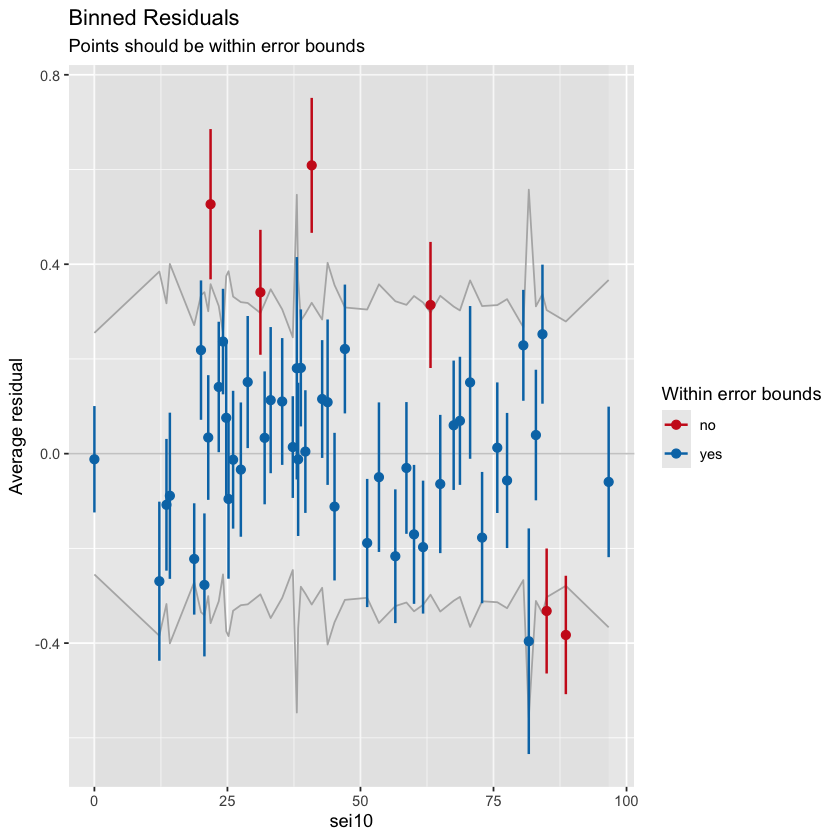

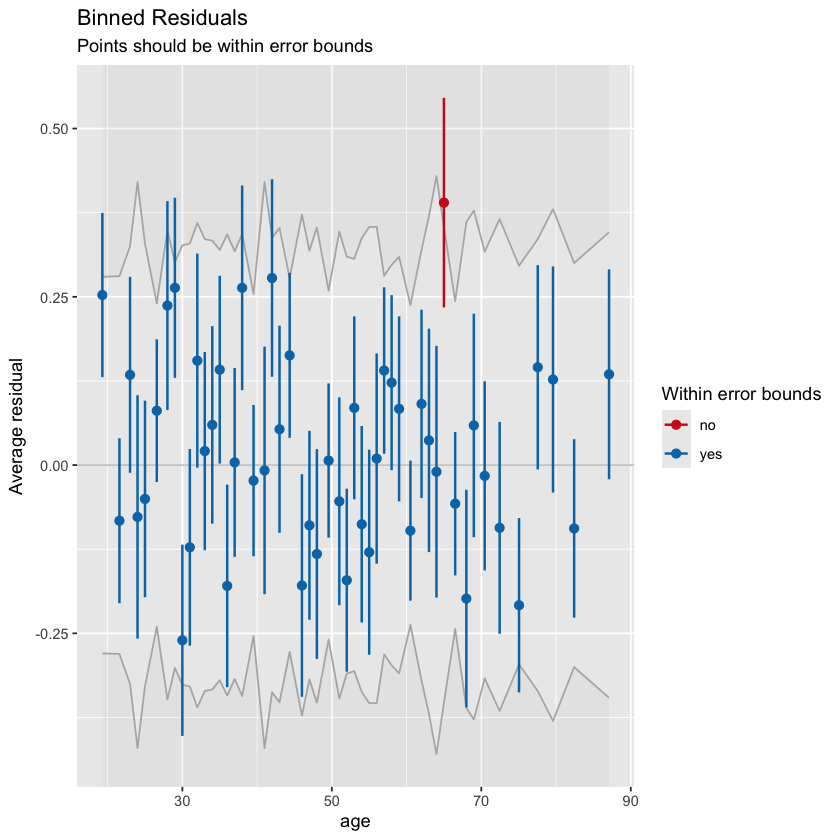

In [30]:
binned_residuals(fit_2, term="sei10")
binned_residuals(fit_2, term="age")

binned_residuals(fit_2, term="sei10") %>% plot(show_dots=TRUE)
binned_residuals(fit_2, term="age") %>% plot(show_dots=TRUE)

Age seems to stick out. It is a better predictor than SES. We may need to add interactions; or add other predictors, like 'polviews', which according to the above model comparisons makes the model significantly better.

In [31]:
emmeans(fit_3, "polviews") %>% pairs() %>% as.data.frame() %>% filter(p.value < .05)

emmeans(fit_3, "polviews", type="response") %>% pairs() %>% as.data.frame() %>% filter(p.value < .05)

contrast,estimate,SE,df,z.ratio,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Extremely liberal - Moderate,-0.9266262,0.1950664,Inf,-4.750312,4.174457e-05
Extremely liberal - Slghtly conservative,-0.8487137,0.2127293,Inf,-3.989642,1.292249e-03
Extremely liberal - Conservative,-0.9935486,0.2108369,Inf,-4.712403,5.024492e-05
Extremely liberal - Extrmly conservative,-1.3402621,0.2792876,Inf,-4.798860,3.285420e-05
Liberal - Moderate,-0.7090022,0.1308520,Inf,-5.418353,1.255181e-06
Liberal - Slghtly conservative,-0.6310897,0.1555805,Inf,-4.056356,9.801139e-04
Liberal - Conservative,-0.7759246,0.1532082,Inf,-5.064512,8.493077e-06
Liberal - Extrmly conservative,-1.1226380,0.2392048,Inf,-4.693210,5.515700e-05
Slightly liberal - Extrmly conservative,-0.7334002,0.2412625,Inf,-3.039843,3.821129e-02


contrast,odds.ratio,SE,df,null,z.ratio,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Extremely liberal / Moderate,0.3958871,0.07722426,Inf,1,-4.750312,4.174457e-05
Extremely liberal / Slghtly conservative,0.4279651,0.09104070,Inf,1,-3.989642,1.292249e-03
Extremely liberal / Conservative,0.3702605,0.07806458,Inf,1,-4.712403,5.024492e-05
Extremely liberal / Extrmly conservative,0.2617771,0.07311109,Inf,1,-4.798860,3.285420e-05
Liberal / Moderate,0.4921350,0.06439684,Inf,1,-5.418353,1.255181e-06
Liberal / Slghtly conservative,0.5320118,0.08277063,Inf,1,-4.056356,9.801139e-04
Liberal / Conservative,0.4602780,0.07051835,Inf,1,-5.064512,8.493077e-06
Liberal / Extrmly conservative,0.3254202,0.07784206,Inf,1,-4.693210,5.515700e-05
Slightly liberal / Extrmly conservative,0.4802732,0.11587191,Inf,1,-3.039843,3.821129e-02


Conservatives are 1/0.37 and 1/0.46 times more likely to support mass transit spending compared to extremely liberal and liberal.

Extreme liberals are 0.37, 0.39, and 0.42 times more likely to support spending compared to conservatives, moderates and slight conservatives.

Extrm conservatives are 1/0.32 and 1/0.48 times more likely to support mass spending than liberals and slight liberals.

Liberals are 0.49 and 0.53 times more likely to support spending than moderates and slight conservatives.

# conclusions

In [32]:
fit_anova = anova(fit_3, test="Chisq")

fit_anova %>%
  kable()



|         | Df|  Deviance| Resid. Df| Resid. Dev|  Pr(>Chi)|
|:--------|--:|---------:|---------:|----------:|---------:|
|NULL     | NA|        NA|      2589|   3581.340|        NA|
|age      |  1|  9.268443|      2588|   3572.072| 0.0023314|
|sex      |  1| 12.156624|      2587|   3559.915| 0.0004891|
|sei10    |  1| 14.119078|      2586|   3545.796| 0.0001716|
|polviews |  6| 63.028441|      2580|   3482.768| 0.0000000|

The model best predicts satisfaction of Mass transportation when it includes age, sex, ses and polviews and predictors. Specifically, conservatives are happier in general to mass transportation than liberals; females are happier towards mass transportation than males; and people of lower socioeconomic status are happier towards mass transportation than people of higher socioeconomic status.